# Read data

In [ ]:
# Запустить один раз ячейку -> Restart Runtime -> повторно запустить ячейку 
# и далее последовательно остальные ячейки ноутбука 
#!pip install ipympl 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
Third-party Jupyter widgets
Support for third party widgets (widgets outside of the ipywidgets package) 
needs to be enabled separately. 
Support for these widgets will be loaded from a CDN external from Colab.
"""
#from google.colab import output
#output.enable_custom_widget_manager()
#output.enable_custom_widget_manager()

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import copy
import pickle
import mne
from zipfile import *

# графические библиотеки
import matplotlib
#import matplotlib.pyplot as plt
%matplotlib widget
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# библиотеки машинного обучения
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import layers

# отображать по умолчанию длину дата Датафрейма
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# библиотека взаимодействия с интерпретатором
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import os

# библиотека вызова функций
import functions as f

import random

In [3]:
# константы и глобальные параметры данных
PATH = 'data/'

# Seed value
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)

# Все исходные файлы размещены в PATH
#PATH = '/content/drive/MyDrive/Programming/test_tasks/Motorika/task_3/' ##
#PATH = '/content/drive/MyDrive/Motorica'

# Папка для сохранения весов лучшей модели при обучении (исп-ся в ModelCheckpoint в функции callbacks)
PATH_BEST_MODEL = 'best_model' 

In [4]:

# Apparently you may use different seed values at each stage

# 1. Set the PYTHONHASHSEED environment variable at a fixed value

# 2. Set the python built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the numpy pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the tensorflow pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global tensorflow session
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
# проверка воспроизводимости результата случайного..
model = keras.Sequential( [ 
layers.Dense(2,name = 'one'),
layers.Dense(3,activation = 'sigmoid', name = 'two'),
layers.Dense(2,name = 'three')])

x = tf.random.uniform((12,12))
model(x)

<tf.Tensor: shape=(12, 2), dtype=float32, numpy=
array([[ 0.84417915, -0.09455603],
       [ 0.6749006 , -0.13408634],
       [ 0.68973166, -0.14211544],
       [ 0.71698654, -0.13607895],
       [ 0.68233585, -0.15881413],
       [ 0.6576998 , -0.15178624],
       [ 0.703879  , -0.13622592],
       [ 0.7794712 , -0.12639348],
       [ 0.8378607 , -0.11526634],
       [ 0.7633468 , -0.1148871 ],
       [ 0.8343782 , -0.09699636],
       [ 0.79229456, -0.12571578]], dtype=float32)>

In [6]:
# Изменили исходный словарь, чтобы далее не распаковывать архив при чтении данных
mounts = {
    1 : {
        'path_X_train' : 'X_train_1.npy',
        'path_y_train' : 'y_train_1.npy',
        'path_X_test_dataset' : 'X_test_dataset_1.pkl',
    },
    2 : {
        'path_X_train' : 'X_train_2.npy',
        'path_y_train' : 'y_train_2.npy',
        'path_X_test_dataset' : 'X_test_dataset_2.pkl',
    },
    3 : {
        'path_X_train' : 'X_train_3.npy',
        'path_y_train' : 'y_train_3.npy',
        'path_X_test_dataset' : 'X_test_dataset_3.pkl',
    }
}

In [11]:
path_to_zip = os.path.join(PATH, 'motorica-advanced-gesture-classification.zip')

for mount_name, mount in mounts.items():
    mount['X_train'] = np.load(path_to_zip)[mount['path_X_train']]
    mount['y_train'] = np.load(path_to_zip)[mount['path_y_train']]
    
    with ZipFile(path_to_zip) as myzip:
        with myzip.open(mount['path_X_test_dataset']) as myfile:
            mount['X_test_dataset'] = pickle.load(myfile)
    print(len(mount['X_test_dataset']))

899
855
861


In [12]:
# Чтение sample_submission.csv из архива
with ZipFile(path_to_zip) as myzip:
    y_test = pd.read_csv(myzip.open('sample_submission.csv'))

y_test[['subject_id', 'sample', 'timestep']] = (
    y_test['subject_id-sample-timestep']
    .str.split('-', 2, expand=True)
    .astype(int)
)
y_test

print(y_test.shape)
y_test.head()
# y_test.set_index(['subject_id', 'sample'])

(471610, 5)


subject_id-sample-timestep  class  subject_id  sample  timestep
0                      1-0-0      4           1       0         0
1                      1-0-1      2           1       0         1
2                      1-0-2      0           1       0         2
3                      1-0-3      0           1       0         3
4                      1-0-4      3           1       0         4

In [13]:
y_test.groupby(['subject_id'])['sample'].nunique()

subject_id
1    899
2    855
3    861
Name: sample, dtype: int64

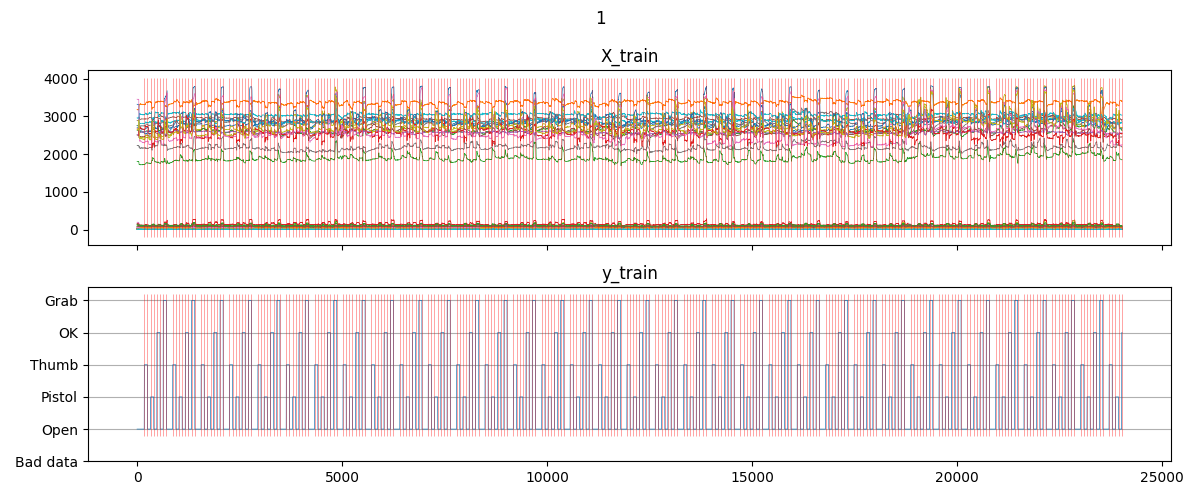

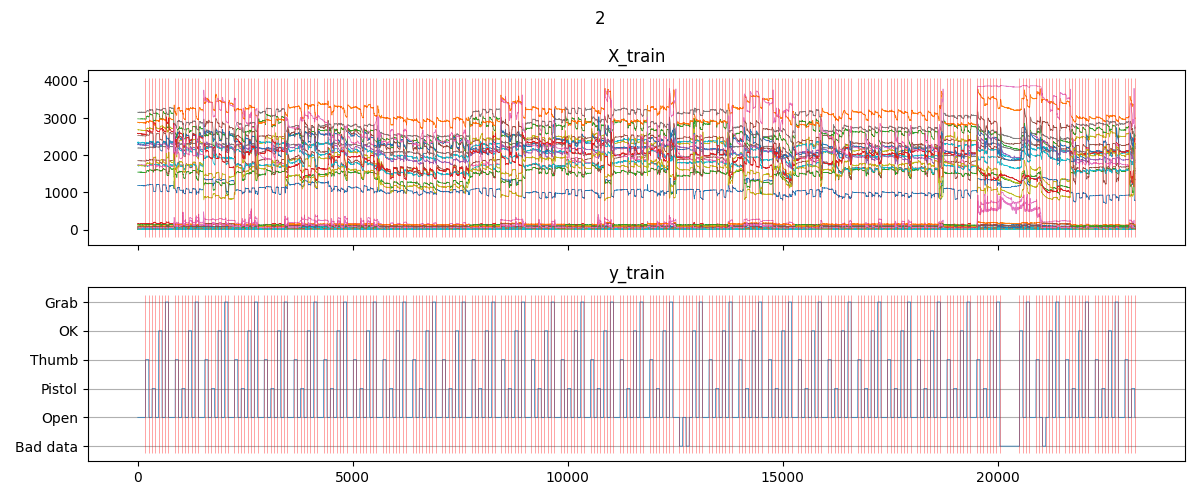

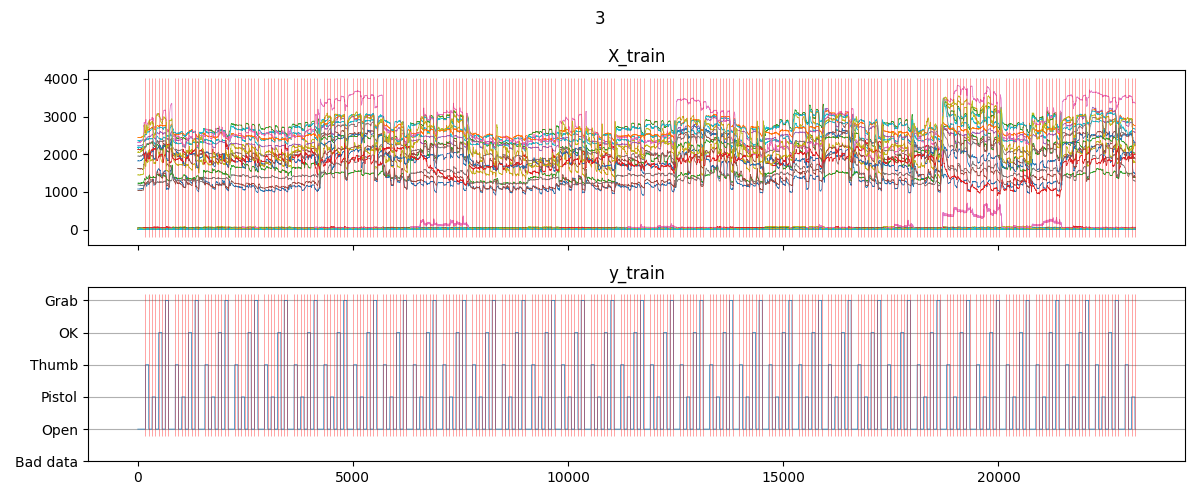

In [14]:
for mount_name, mount in mounts.items():
    X_train = mount['X_train']
    y_train = mount['y_train']
    
    events = np.where(np.abs(np.diff(y_train)) > 0)[0]
    
    fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
    plt.sca(axx[0])
    plt.plot(X_train, lw=0.5)
    plt.title('X_train')
    yl = plt.ylim()
    plt.vlines(events, *yl, color='r', lw=0.5, alpha=0.5)
    
    plt.sca(axx[1])
    plt.plot(y_train, lw=0.5)
    plt.title('y_train')
    yl = plt.ylim()
    plt.vlines(events, *yl, color='r', lw=0.5, alpha=0.5)
    plt.yticks(
        np.arange(-1, 5),
        ['Bad data', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
    )
    plt.grid(axis='y')
    
    plt.suptitle(f"{mount_name}")
    plt.tight_layout()
    plt.show()

In [17]:
SFREQ = 1000.0 / 33

for mount_name, mount in mounts.items():
    X_train = mount['X_train'] 
    y_train = mount['y_train']
    
    raw = mne.io.RawArray(
        data=X_train.T,
        info=mne.create_info(
            ch_names=list(np.arange(X_train.shape[1]).astype(str)),
            sfreq=SFREQ,
            ch_types='eeg'
        )
    )
    raw_y = mne.io.RawArray(
        data=y_train.reshape(1,-1),
        info=mne.create_info(
            ch_names=['y'],
            sfreq=SFREQ,
            ch_types='misc'
        )
    )
    raw = raw.add_channels([raw_y])
    
    mount['raw'] = raw

Creating RawArray with float64 data, n_channels=50, n_times=24030
    Range : 0 ... 24029 =      0.000 ...   792.957 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=24030
    Range : 0 ... 24029 =      0.000 ...   792.957 secs
Ready.
Creating RawArray with float64 data, n_channels=50, n_times=23202
    Range : 0 ... 23201 =      0.000 ...   765.633 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=23202
    Range : 0 ... 23201 =      0.000 ...   765.633 secs
Ready.
Creating RawArray with float64 data, n_channels=50, n_times=23177
    Range : 0 ... 23176 =      0.000 ...   764.808 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=23177
    Range : 0 ... 23176 =      0.000 ...   764.808 secs
Ready.


In [18]:
for mount_name, mount in mounts.items():
    raw = mount['raw']
    y_train = mount['y_train']
        
    events = np.where(np.abs(np.diff(y_train)) > 0)[0]

    events = np.stack([
        events,
        np.zeros_like(events),
        np.zeros_like(events)
    ], axis=1)
    
    
    epochs = mne.Epochs(
        raw,
        events=events,
        tmin=-1, 
        tmax=1*2.5, 
        preload=True,
        baseline=None,
        picks='all'
    )
    
    X_train_nn = epochs.copy().pick_types(eeg =True)._data.swapaxes(1, 2)
    y_train_nn = epochs.copy().pick_types(misc=True)._data.swapaxes(1, 2)
    y_train_nn = tf.keras.utils.to_categorical(y_train_nn)
    
    mount['X_train_nn'] = X_train_nn
    mount['y_train_nn'] = y_train_nn

    print(X_train_nn.shape, y_train_nn.shape)

Not setting metadata
277 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 277 events and 107 original time points ...
1 bad epochs dropped
(276, 107, 50) (276, 107, 5)
Not setting metadata
264 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 264 events and 107 original time points ...
1 bad epochs dropped
(263, 107, 50) (263, 107, 5)
Not setting metadata
268 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 268 events and 107 original time points ...
1 bad epochs dropped
(267, 107, 50) (267, 107, 5)


# Model architecture

In [19]:
# Функция для расчета метрики f1_score, Precision, Recall
# Примечание: Metrics have been removed from Keras core on 2.0 version
# https://stackoverflow.com/questions/66554207/calculating-micro-f-1-score-in-keras

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """
        Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """
        Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives/(predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision + recall + K.epsilon()))

# Callbacks that used for training model
def callbacks(lr, num_train):
    checkpoint = ModelCheckpoint(
        os.path.join(PATH_BEST_MODEL, 'best_model_rnn_' + str(num_train) + '.hdf5'), 
        monitor='val_f1', 
        verbose=1, 
        mode='max', 
        save_best_only=True
    )

    earlystop = EarlyStopping(
        monitor='val_f1', 
        mode='max', 
        patience=200, 
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_f1', 
        mode='max', 
        factor=0.9, 
        patience=15, # можно 10
        verbose=1, 
        min_lr=lr/10000
    )
    
    return [checkpoint, earlystop, reduce_lr]


def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(seed_value)
   tf.random.set_seed(seed_value)
   np.random.seed(seed_value)
   random.seed(seed_value)

In [20]:
_, n_timesteps, n_channels = X_train_nn.shape
output_units = y_train_nn.shape[-1]
print(f"input_shape = {(n_timesteps, n_channels)} | output_units = {output_units}")

input_channels = x = tf.keras.layers.Input(shape=(n_timesteps, n_channels))

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.SimpleRNN(
    units=100,
    return_sequences=True,
    #dropout=0.1, 
    #recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3),
)(x)
x = tf.keras.layers.BatchNormalization()(x)

#x = tf.keras.layers.SimpleRNN(
#    units=100,
#    return_sequences=True,
#    #dropout=0.5,
#    #recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2),
#)(x)

output = tf.keras.layers.Dense(units=output_units, activation='sigmoid')(x)

model = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model"
)

model.summary()

#tf.keras.utils.plot_model(model, show_shapes=True)

input_shape = (107, 50) | output_units = 5
Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 107, 50)]         0         
                                                                 
 batch_normalization (BatchN  (None, 107, 50)          200       
 ormalization)                                                   
                                                                 
 simple_rnn (SimpleRNN)      (None, 107, 100)          15100     
                                                                 
 batch_normalization_1 (Batc  (None, 107, 100)         400       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 107, 5)            505       
                                                                 
Total params: 16,2

## Model train

In [21]:
# создаем словарь, в котором будем накапливать предсказания SimpleRNN на X_train 
# при разных validation_split в m.fit
x_trn_pred_dict = dict(zip(list(mounts.keys()), [[],[],[]]))

for splt_coef in range(10,100,25): # кол-во разных тренировок зависит от числа разбиений.
    
    val_splt_coef = splt_coef/100
    
    for mount_name, mount in mounts.items():
        
        X_train_nn = mount['X_train_nn']
        y_train_nn = mount['y_train_nn']
        
        tf.keras.backend.clear_session()
        reset_random_seeds() # сброс и задание random seed
        
        m = tf.keras.models.clone_model(model)
        m.compile(
            loss="mean_squared_error", 
            metrics=[f1], 
            optimizer=tf.keras.optimizers.Adam(), # по умолчанию learning rate=10e-3
        )
        
        history = m.fit(
            X_train_nn, 
            y_train_nn, 
            validation_split=val_splt_coef,
            epochs=500,
            verbose=1,
            callbacks=callbacks(lr=0.001, 
                                num_train=mount_name)
        )
        
        y_pred_train_nn = m.predict(X_train_nn) 
        print(y_pred_train_nn.shape)
        
        mount['model'] = m
        mount['y_pred_train_nn'] = y_pred_train_nn
        x_trn_pred_dict[mount_name].append(y_pred_train_nn)

Epoch 1/500
8/8 [==============================] - ETA: 0s - loss: 0.2576 - f1: 0.4175
Epoch 1: val_f1 improved from -inf to 0.40476, saving model to best_model\best_model_rnn_1.hdf5
8/8 [==============================] - 2s 73ms/step - loss: 0.2576 - f1: 0.4175 - val_loss: 0.2676 - val_f1: 0.4048 - lr: 0.0010
Epoch 2/500
6/8 [=====================>........] - ETA: 0s - loss: 0.2163 - f1: 0.4988
Epoch 2: val_f1 did not improve from 0.40476
8/8 [==============================] - 0s 27ms/step - loss: 0.2136 - f1: 0.5038 - val_loss: 0.2619 - val_f1: 0.4047 - lr: 0.0010
Epoch 3/500
7/8 [=========================>....] - ETA: 0s - loss: 0.1903 - f1: 0.5460
Epoch 3: val_f1 did not improve from 0.40476
8/8 [==============================] - 0s 27ms/step - loss: 0.1895 - f1: 0.5490 - val_loss: 0.2664 - val_f1: 0.4048 - lr: 0.0010
Epoch 4/500
6/8 [=====================>........] - ETA: 0s - loss: 0.1711 - f1: 0.5932
Epoch 4: val_f1 did not improve from 0.40476
8/8 [=============================

In [22]:
# смотрим размерность id_pilot=1, наблюдения 1 (для примера)
x_trn_pred_dict[1][0].shape

(276, 107, 5)

## Visualisation

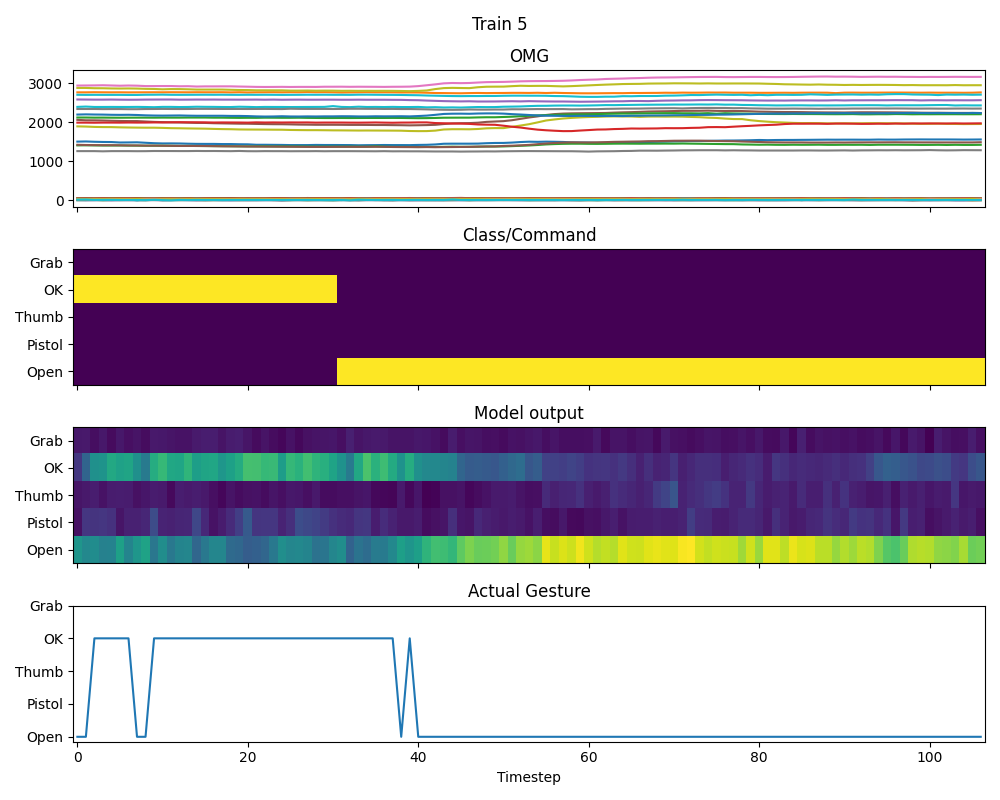

In [23]:
id_pilot = 3
mount = mounts[id_pilot]         # выбираем номер пилота
X_train_nn = mount['X_train_nn']
y_train_nn = mount['y_train_nn']
y_pred_train_nn = mount['y_pred_train_nn']
y_pred_train_nn_mean = np.mean(x_trn_pred_dict[id_pilot], axis=0)

i = 5                            # выбираем номер наблюдения

fig, axx = plt.subplots(4, 1, sharex=True, figsize=(10, 8))

axx[0].plot(X_train_nn[i])
axx[0].set_title('OMG')

axx[1].imshow(y_train_nn[i].T, origin="lower")
axx[1].set_aspect('auto')
axx[1].set_title('Class/Command')
axx[1].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)

axx[2].imshow(y_pred_train_nn_mean[i].T, origin="lower")
axx[2].set_aspect('auto')
axx[2].set_title('Model output')
axx[2].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)

axx[3].plot(y_pred_train_nn_mean[i].argmax(axis=-1))
axx[3].set_aspect('auto')
axx[3].set_title('Actual Gesture')
axx[3].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)
axx[3].set_xlabel('Timestep')

plt.suptitle(f'Train {i}')
plt.tight_layout()
#plt.gcf()

# Model architecture LSTM

In [24]:
# Callbacks that used for training model
def callbacks(lr, num_train):
    checkpoint = ModelCheckpoint(os.path.join(PATH_BEST_MODEL, 'best_model_'+str(num_train)+'.hdf5'), monitor='val_f1', 
                                 verbose=1, mode='max', save_best_only=True)
    earlystop = EarlyStopping(monitor='val_f1', mode='max', patience=200, restore_best_weights=True) # было patience=300
    reduce_lr = ReduceLROnPlateau(monitor='val_f1', mode='max', factor=0.9, patience=10, verbose=1, 
                                  min_lr=lr/10000)
    return [checkpoint, earlystop, reduce_lr]

callbacks_list = callbacks(lr=0.001, num_train=1)

In [25]:
_, n_timesteps, n_channels = X_train_nn.shape
output_units = np.mean(x_trn_pred_dict[3], axis=0).shape[-1]
print(f"input_shape = {(n_timesteps, n_channels)} | output_units = {output_units}")

input_channels = x = tf.keras.layers.Input(shape=(n_timesteps, n_channels))

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LSTM(100, return_sequences=True)(x)
x = tf.keras.layers.LSTM(100, return_sequences=True)(x)
x = tf.keras.layers.LSTM(100, return_sequences=True)(x)
x = tf.keras.layers.LSTM(100, return_sequences=True, dropout=0.5)(x) #
#x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(units=output_units, activation='softmax')(x)

model_lstm = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model_LSTM"
)

model_lstm.summary()

input_shape = (107, 50) | output_units = 5
Model: "Model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 107, 50)]         0         
                                                                 
 batch_normalization (BatchN  (None, 107, 50)          200       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 107, 100)          60400     
                                                                 
 lstm_1 (LSTM)               (None, 107, 100)          80400     
                                                                 
 lstm_2 (LSTM)               (None, 107, 100)          80400     
                                                                 
 lstm_3 (LSTM)               (None, 107, 100)          80400     
             

In [26]:
# Для отображения в Colab "You must install pydot (`pip install pydot`) and install graphviz.
# (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work."

# tf.keras.utils.plot_model(model_lstm, show_shapes=True)

## Model train

In [27]:
# Смотрим размерность тренировочных данных перед подачей в модель LSTM для пилота 1
mounts[1]['X_train_nn'].shape

(276, 107, 50)

In [28]:
# Смотрим размерность целевой переменной перед подачей в модель LSTM для пилота 1
mounts[1]['y_train_nn'].shape

(276, 107, 5)

In [29]:
# Смотрим размерность усредненной предсказанной целевой переменной перед подачей в модель LSTM для пилота 1
# чтобы сравнить с размерностью целевой переменной (проверяем правильность)
np.mean(x_trn_pred_dict[1], axis=0).shape

(276, 107, 5)

In [30]:
def plot_history(history):
    
    """
    history - create from model.fit
        
    """
    
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    #acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    f1_sc = history.history['f1']  
    loss = history.history['loss']

    f1_sc_val = history.history['val_f1'] # на валидационной выборке
    val_loss = history.history['val_loss']

    epochs = range(len(f1_sc))

    #plt.plot(epochs, acc, 'b', label='Training acc')
    #plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.plot(epochs, f1_sc, 'b', label='Training f1_score')
    plt.plot(epochs, f1_sc_val, 'r', label='Training val_f1_score')
    plt.title('Training f1_score') # изменение f1-score
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training loss')
    plt.legend()

    plt.show()

In [31]:
for mount_name, mount in mounts.items():
    X_train_nn = mount['X_train_nn']
    y_pred_train_nn = np.mean(x_trn_pred_dict[mount_name], axis=0).argmax(axis=-1)
    y_pred_train_nn = tf.keras.utils.to_categorical(y_pred_train_nn)
    
    tf.keras.backend.clear_session()
    reset_random_seeds() # сброс и задание random seed
    m_lstm = tf.keras.models.clone_model(model_lstm)
    m_lstm.compile(
        loss="categorical_crossentropy",
        metrics=[f1],
        optimizer=tf.keras.optimizers.Adam(), #learning_rate можно поменять в Adam, например, на 0.01
    )
    
    history = m_lstm.fit(
        X_train_nn,
        y_pred_train_nn,
        validation_split=0.2, # validation_split можно менять. Поменял с 0.15 до 0.2
        epochs=1500,
        verbose=1,
        callbacks=callbacks(lr=0.001, num_train=mount_name)
    )

    mount['history'] = history
    
    mount['model_lstm'] = m_lstm
    
    # Расчеты ниже нужны, чтобы посмотреть результат предсказания для модели LSTM на X_train_nn
    y_pred_train_lstm = m_lstm.predict(X_train_nn)
    print(y_pred_train_lstm.shape)
    mount['y_pred_train_lstm'] = y_pred_train_lstm

Epoch 1/1500
7/7 [==============================] - ETA: 0s - loss: 1.4778 - f1: 0.4282
Epoch 1: val_f1 improved from -inf to 0.00000, saving model to best_model\best_model_1.hdf5
7/7 [==============================] - 9s 517ms/step - loss: 1.4778 - f1: 0.4282 - val_loss: 1.5428 - val_f1: 0.0000e+00 - lr: 0.0010
Epoch 2/1500
7/7 [==============================] - ETA: 0s - loss: 0.9458 - f1: 0.6753
Epoch 2: val_f1 did not improve from 0.00000
7/7 [==============================] - 2s 300ms/step - loss: 0.9458 - f1: 0.6753 - val_loss: 1.4956 - val_f1: 0.0000e+00 - lr: 0.0010
Epoch 3/1500
7/7 [==============================] - ETA: 0s - loss: 0.7072 - f1: 0.7600
Epoch 3: val_f1 did not improve from 0.00000
7/7 [==============================] - 2s 298ms/step - loss: 0.7072 - f1: 0.7600 - val_loss: 1.4092 - val_f1: 0.0000e+00 - lr: 0.0010
Epoch 4/1500
7/7 [==============================] - ETA: 0s - loss: 0.6097 - f1: 0.7948
Epoch 4: val_f1 did not improve from 0.00000
7/7 [==============

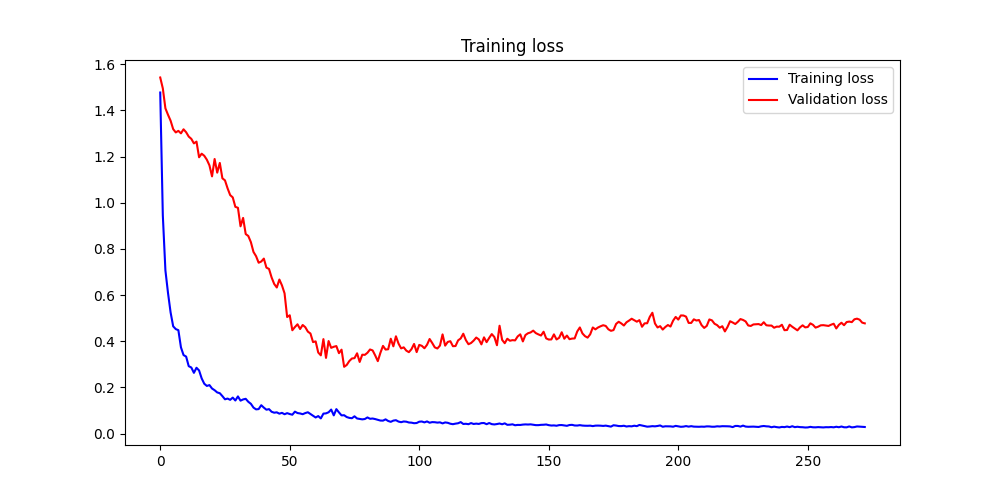

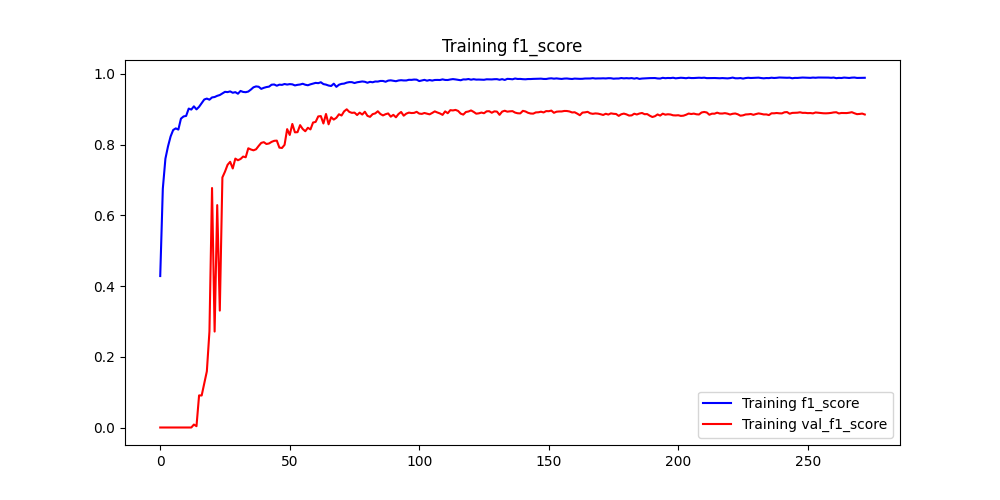

In [32]:
plot_history(mounts[1]['history'])

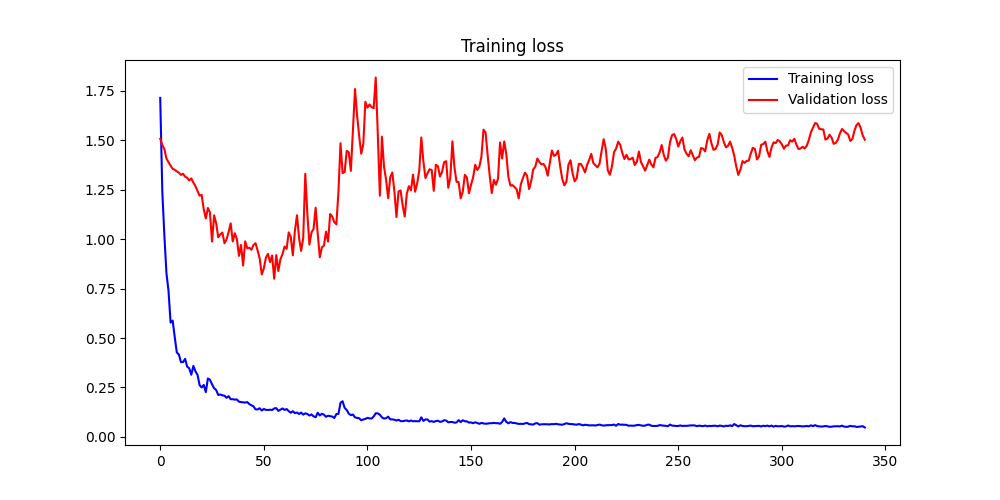

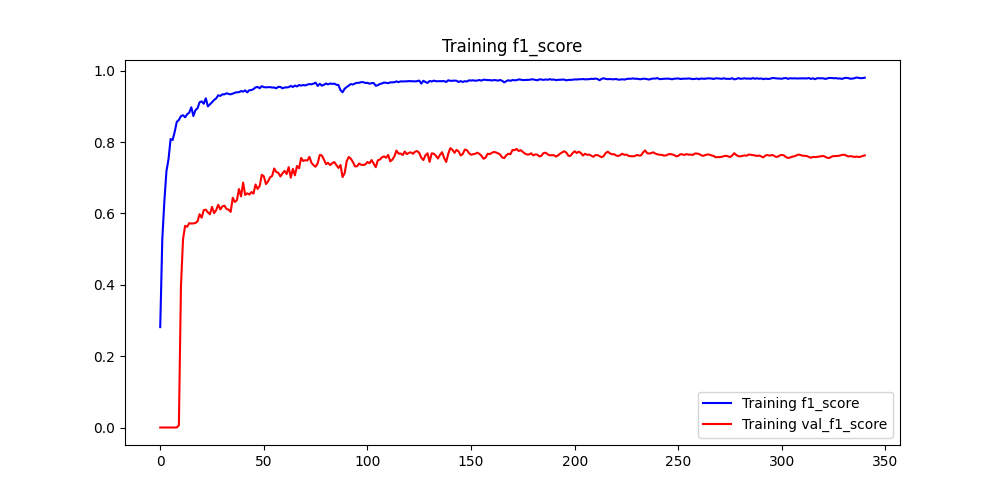

In [33]:
plot_history(history)

## Visualisation

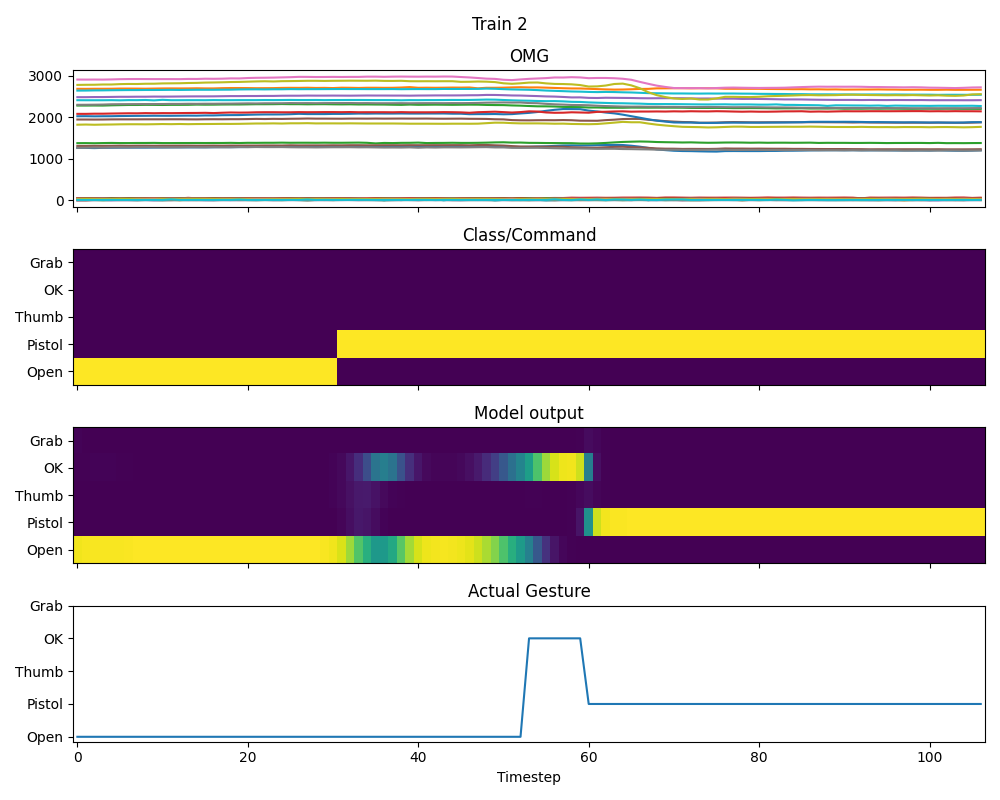

In [34]:
id_pilot = 3
mount = mounts[id_pilot]         # выбираем номер пилота
X_train_nn = mount['X_train_nn']
y_train_nn = mount['y_train_nn']
y_pred_train_lstm = mount['y_pred_train_lstm']

i = 2                            # выбираем номер наблюдения

fig, axx = plt.subplots(4, 1, sharex=True, figsize=(10, 8))

axx[0].plot(X_train_nn[i])
axx[0].set_title('OMG')

axx[1].imshow(y_train_nn[i].T, origin="lower")
axx[1].set_aspect('auto')
axx[1].set_title('Class/Command')
axx[1].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)

axx[2].imshow(y_pred_train_lstm[i].T, origin="lower")
axx[2].set_aspect('auto')
axx[2].set_title('Model output')
axx[2].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)

axx[3].plot(y_pred_train_lstm[i].argmax(axis=-1))
axx[3].set_aspect('auto')
axx[3].set_title('Actual Gesture')
axx[3].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)
axx[3].set_xlabel('Timestep')

plt.suptitle(f'Train {i}')
plt.tight_layout()
#plt.gcf()

# Predict test & submit LSTM

In [35]:
for mount_name, mount in mounts.items():
    m_lstm = mount['model_lstm']
    X_train_nn = mount['X_train_nn']
    X_test_dataset = mount['X_test_dataset']
    
    y_pred_test_lstm = []
    for i in range(len(X_test_dataset)):
        X_test_i = np.expand_dims(X_test_dataset[i], axis=0).swapaxes(1, 2).astype(np.float64)
        y_pred_test_lstm += [m_lstm.predict(X_test_i, verbose=0)]
        
    y_pred_test_lstm = [arr.argmax(axis=-1) for arr in y_pred_test_lstm]
    
    print(len(y_pred_test_lstm))
    assert len(y_pred_test_lstm) == y_test.query("subject_id == @mount_name")['sample'].nunique()
    
    mount['y_pred_test_lstm'] = y_pred_test_lstm

899
855
861


In [36]:
y_pred_test_res = []
for mount_name, mount in mounts.items():
    y_pred_test_res.extend(mount['y_pred_test_lstm'])
y_pred_test_res = np.concatenate(y_pred_test_res, axis=-1)[0]

assert y_pred_test_res.shape[0] == y_test.shape[0]

In [37]:
y_test_submit = y_test[['subject_id-sample-timestep', 'class']]
y_test_submit['class'] = y_pred_test_res
y_test_submit.to_csv('./y_test_submit_rnn_LSTM.csv', index=False)

y_test_submit

subject_id-sample-timestep  class
0                           1-0-0      0
1                           1-0-1      0
2                           1-0-2      0
3                           1-0-3      0
...                           ...    ...
471606                  3-860-177      0
471607                  3-860-178      0
471608                  3-860-179      0
471609                  3-860-180      0

[471610 rows x 2 columns]

In [38]:
# загрузка y_test_submit_rnn_LSTM.csv для отправки на Kaggle
#from google.colab import files
#files.download('./y_test_submit_rnn_LSTM.csv')

In [ ]:
# Сохраняем результат предсказания модели в отдельный файл
y_test = pd.read_csv(os.path.join(PATH, './y_test_submit_rnn_LSTM.csv'))
#y_test['class'] = y_pred
y_test.to_csv(PATH_BEST_MODEL+'y_test_4lstm.csv', index=False)
y_test